## Introduction and references

I was first made aware of this issue in http://haldanessieve.org/2014/03/21/author-post-genetic-influences-on-translation-in-yeast/, so we need to cite the post or the article.

For other informative references, see http://en.wikipedia.org/wiki/Total_least_squares and http://en.wikipedia.org/wiki/Errors-in-variables_models.  The problem we are trying to avoid here is attenuation bias or regression dilution (see http://en.wikipedia.org/wiki/Regression_dilution).

## Mass spec data and fitting

In [4]:
import numpy, pandas, scipy.stats, seaborn, pylab, scipy.odr
%matplotlib inline

In [5]:
ms2_both_species = pandas.read_csv("Data_for_interference_ratios_plots/ALE_interference_set2_Y+H_MS2_BH.csv", index_col=1)
ms3_both_species = pandas.read_csv("Data_for_interference_ratios_plots/ALE_interference_set2_Y+H_MS3_BH.csv", index_col=1)
ms2_yeast = pandas.read_csv("Data_for_interference_ratios_plots/ALE_interference_set2_Y_only_MS2_BH.csv", index_col=1)
ms3_yeast = pandas.read_csv("Data_for_interference_ratios_plots/ALE_interference_set2_Y_only_MS3_BH.csv", index_col=1)

In [18]:
ms2_both_species.head()

,Unnamed: 0,126 Vert Med,127n Vert Med,127c Vert Med,128n Vert Med,128c Vert Med,129n Vert Med,batch_p_value,null_batch_p_value,1 vs 2,i_value,BH_value,Significant?,PepPerProt
ProteinID,,,,,,,,,,,,,,
YML009C,2819,312293.6903,307372.8028,305317.1813,853742.5699,835432.8687,842676.5201,4.170000e-08,0.512384,7.750000e-08,1,0.000172,True,1
YLR262C-A,2678,330290.1674,324090.2799,335944.6204,828722.5448,825534.7961,825114.2173,1.010000e-07,0.535342,1.670000e-08,2,0.000209,True,3
YCL026C-B,369,333521.3955,339539.8643,336577.0073,813773.4845,838498.8366,812688.3767,1.620000e-07,0.530168,5.930000e-07,3,0.000222,True,4
YJR060W,2163,853279.8707,836501.0098,842738.7702,395246.2931,406929.1902,400412.0544,2.130000e-07,0.490065,1.940000e-07,4,0.000219,True,5
Q0045,0,234746.4291,235839.0890,243317.0553,890467.3684,934305.2072,887251.1147,3.080000e-07,0.546969,1.720000e-06,5,0.000254,True,3


In [6]:
cols1 = ["126 Vert Med", "127n Vert Med", "127c Vert Med"]
cols2 = ["128n Vert Med", "128c Vert Med", "129n Vert Med"]

merged = pandas.DataFrame()

# not the best code here...
merged["MS2_both_species_ratios"] = ms2_both_species[cols2].mean(axis=1) / ms2_both_species[cols1].mean(axis=1)
merged["MS3_both_species_ratios"] = ms3_both_species[cols2].mean(axis=1) / ms3_both_species[cols1].mean(axis=1)

merged["MS2_yeast_ratios"] = ms2_yeast[cols2].mean(axis=1) / ms2_yeast[cols1].mean(axis=1)
merged["MS3_yeast_ratios"] = ms3_yeast[cols2].mean(axis=1) / ms3_yeast[cols1].mean(axis=1)

print merged.shape

(4117, 4)


In [51]:
bla = """ # worried about the ODR param order
temp = numpy.log2(merged[["MS2_yeast_ratios", "MS2_both_species_ratios"]].dropna())
x = temp[temp.columns[0]]
y = temp[temp.columns[1]]
seaborn.jointplot(x, y, kind="reg")
print scipy.stats.linregress(x, y)
print scipy.stats.linregress(y, x)
b_hat1 = scipy.odr.odr(lambda b, x : b[0]*x + b[1], [1.0, 0.0], x, y, full_output=False)[0]
print b_hat1
pylab.plot(x, b_hat1[0]*x + b_hat1[1], "k:")
b_hat2 = scipy.odr.odr(lambda b, x : b[0]*x + b[1], [1.0, 0.0], y, x, full_output=False)[0]
print b_hat2
pylab.plot(b_hat2[0]*y + b_hat2[1], y, "m:")
pylab.show()
"""

In [50]:
bla = """
temp = numpy.log2(merged[["MS3_yeast_ratios", "MS3_both_species_ratios"]].dropna())
x = temp[temp.columns[0]]
y = temp[temp.columns[1]]
seaborn.jointplot(x, y, kind="reg")
print scipy.stats.linregress(x, y)
print scipy.stats.linregress(y, x)
b_hat1 = scipy.odr.odr(lambda b, x : b[0]*x + b[1], [1.0, 0.0], x, y, full_output=False)[0]
print b_hat1
pylab.plot(x, b_hat1[0]*x + b_hat1[1], "k:")
b_hat2 = scipy.odr.odr(lambda b, x : b[0]*x + b[1], [1.0, 0.0], y, x, full_output=False)[0]
print b_hat2
pylab.plot(b_hat2[0]*y + b_hat2[1], y, "m:")
pylab.show()
"""

## New results for Amanda (MS2 vs. MS3)

In [52]:
# trying to factor out the previous code for shared reuse now...
def compare_columns(name1, name2):
    temp = numpy.log2(merged[[name1, name2]].dropna())
    x = temp[name1]
    y = temp[name2]
    seaborn.jointplot(x, y, kind="reg")
    print "regressing y onto x (%s onto %s) (slope, intercept, ...):\n\t" % (name2, name1), scipy.stats.linregress(x, y)
    print "regressing x onto y (%s onto %s) (slope, intercept, ...):\n\t" % (name1, name2), scipy.stats.linregress(y, x)
    b_hat1 = scipy.odr.odr(lambda b, x : b[0]*x + b[1], [1.0, 0.0], y, x, full_output=False)[0]
    print "ODR of y onto x (slope, intercept):", b_hat1
    pylab.plot(x, b_hat1[0]*x + b_hat1[1], "k:")
    b_hat2 = scipy.odr.odr(lambda b, x : b[0]*x + b[1], [1.0, 0.0], x, y, full_output=False)[0]
    print "ODR of x onto y (slope, intercept):", b_hat2
    pylab.plot(b_hat2[0]*y + b_hat2[1], y, "m:")
    print "magenta and black dotted lines are from ODR fits"
    pylab.show()

regressing y onto x (MS3_yeast_ratios onto MS2_yeast_ratios) (slope, intercept, ...):
	(1.0486696581602073, 0.0094855321993108921, 0.81705647172198148, 0.0, 0.011796603911594849)
regressing x onto y (MS2_yeast_ratios onto MS3_yeast_ratios) (slope, intercept, ...):
	(0.63659825836286887, 0.00885594819264654, 0.81705647172198148, 0.0, 0.007161166003308371)
ODR of y onto x (slope, intercept): [ 1.35514625 -0.00424673]
ODR of x onto y (slope, intercept): [ 0.73790451  0.00313493]
magenta and black dotted lines are from ODR fits


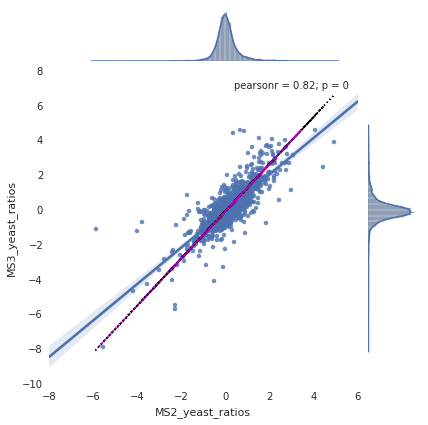

In [53]:
compare_columns("MS2_yeast_ratios", "MS3_yeast_ratios")

regressing y onto x (MS3_both_species_ratios onto MS2_both_species_ratios) (slope, intercept, ...):
	(1.1754410945736571, -0.011205502268446091, 0.8278694436507088, 0.0, 0.01367050853643496)
regressing x onto y (MS2_both_species_ratios onto MS3_both_species_ratios) (slope, intercept, ...):
	(0.58307287272368424, 0.023592570545526506, 0.8278694436507088, 0.0, 0.0067812013045399754)
ODR of y onto x (slope, intercept): [ 1.52151882 -0.02996931]
ODR of x onto y (slope, intercept): [ 0.6572303   0.01969748]
magenta and black dotted lines are from ODR fits


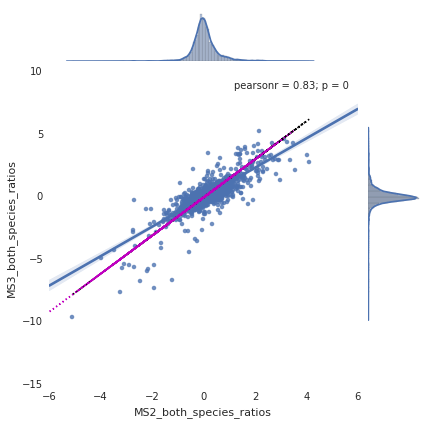

In [54]:
compare_columns("MS2_both_species_ratios", "MS3_both_species_ratios")

## Newest results for Amanda (ODR MS2 vs. MS3, with some truncation to exclude outliers)

In [59]:
# trying to factor out the previous code for shared reuse now...
def compare_columns_truncated(name1, name2, truncate=True, merged=merged):
    temp = numpy.log2(merged[[name1, name2]].dropna())
    print "we're starting with", len(temp), "datapoints"
    if truncate:
        temp = temp[(numpy.abs(temp[name1]) <= 2) & (numpy.abs(temp[name2]) <= 2)]
    x = temp[name1]
    y = temp[name2]
    print "filtered based on max ratios to", len(temp), "datapoints"
    seaborn.jointplot(x, y, kind="reg")
    print "(plain) regressing y onto x (%s onto %s) (slope, intercept, ...):\n\t" % (name2, name1), scipy.stats.linregress(x, y)
    print "(plain) regressing x onto y (%s onto %s) (slope, intercept, ...):\n\t" % (name1, name2), scipy.stats.linregress(y, x)
    b_hat1 = scipy.odr.odr(lambda b, x : b[0]*x + b[1], [1.0, 0.0], y, x, full_output=False)[0]
    print "ODR of y onto x (slope, intercept):", b_hat1
    pylab.plot(x, b_hat1[0]*x + b_hat1[1], "k:")
    b_hat2 = scipy.odr.odr(lambda b, x : b[0]*x + b[1], [1.0, 0.0], x, y, full_output=False)[0]
    print "ODR of x onto y (slope, intercept):", b_hat2
    pylab.plot(b_hat2[0]*y + b_hat2[1], y, "m:")
    print "magenta and black dotted lines are from ODR fits"
    pylab.show()

regressing y onto x (MS3_yeast_ratios onto MS2_yeast_ratios) (slope, intercept, ...):
	(1.0486696581602073, 0.0094855321993108921, 0.81705647172198148, 0.0, 0.011796603911594849)
regressing x onto y (MS2_yeast_ratios onto MS3_yeast_ratios) (slope, intercept, ...):
	(0.63659825836286887, 0.00885594819264654, 0.81705647172198148, 0.0, 0.007161166003308371)
ODR of y onto x (slope, intercept): [ 1.35514625 -0.00424673]
ODR of x onto y (slope, intercept): [ 0.73790451  0.00313493]
magenta and black dotted lines are from ODR fits


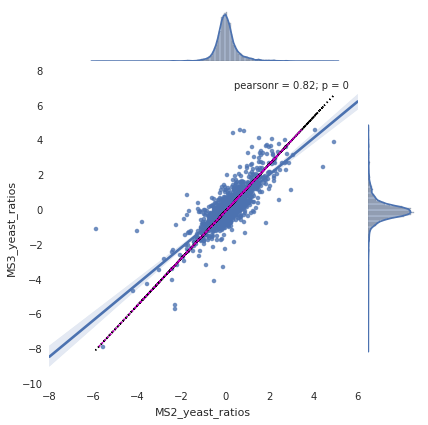

In [60]:
compare_columns("MS2_yeast_ratios", "MS3_yeast_ratios")

we're starting with 3937 datapoints
filtered based on max ratios to 3828 datapoints
(plain) regressing y onto x (MS3_yeast_ratios onto MS2_yeast_ratios) (slope, intercept, ...):
	(0.95507808705903441, -0.00082682852090025169, 0.78227008672618803, 0.0, 0.012295762992576684)
(plain) regressing x onto y (MS2_yeast_ratios onto MS3_yeast_ratios) (slope, intercept, ...):
	(0.64072927321676953, 0.010528404184417887, 0.78227008672618803, 0.0, 0.0082488074981793055)
ODR of y onto x (slope, intercept): [ 1.28928547 -0.00943803]
ODR of x onto y (slope, intercept): [ 0.77561154  0.00732065]
magenta and black dotted lines are from ODR fits


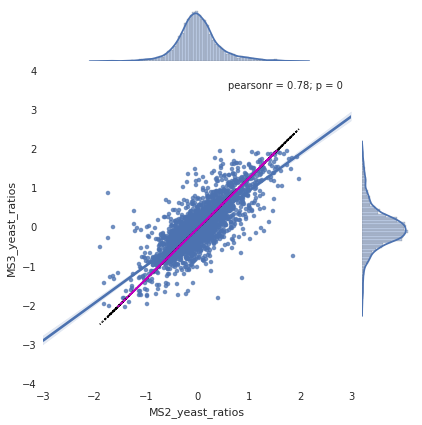

In [61]:
compare_columns_truncated("MS2_yeast_ratios", "MS3_yeast_ratios")

we're starting with 8 datapoints
filtered based on max ratios to 8 datapoints
(plain) regressing y onto x (y onto x) (slope, intercept, ...):
	(1.9844820935821732, 0.10752455271044248, 0.99841075006395252, 1.0023025163247928e-08, 0.045729956764791461)
(plain) regressing x onto y (x onto y) (slope, intercept, ...):
	(0.50230940811559799, -0.039679011047606849, 0.99841075006395252, 1.0023025163247928e-08, 0.011575104451665904)
ODR of y onto x (slope, intercept): [ 1.98952705  0.08475919]
ODR of x onto y (slope, intercept): [ 0.50263219 -0.04260451]
magenta and black dotted lines are from ODR fits


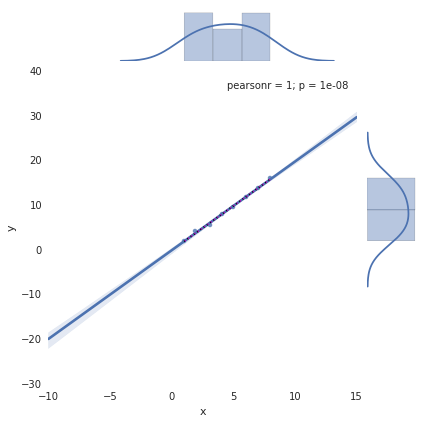

In [62]:
# so let's run a test case where the equation is definitely y = 2 * x (more or less)
test_df = pandas.DataFrame({"x":[1.0,1.9,3.1,4.1,5,6,7,8], 
                            "y":[2.2, 4.3, 5.8, 8.1, 9.8, 12.1, 14.0, 16.2]})
test_df = numpy.power(2, test_df) # because the method log2's everything

compare_columns_truncated("x", "y", False, test_df)
# regression lines should all match up, with all y-on-x regressions having slope of ~2

## Extending to heteroscedastic errors

In [96]:
print numpy.average(numpy.log2(df[cols]), axis=0).shape

(3,)


MS2_yeast 0.0286266057367 0.0201464872006
MS3_yeast 0.0204832414001 0.0163967362214
MS2_both_species 0.0314870413762 0.0238624313965
MS3_both_species 0.0288823336392 0.0265519320631


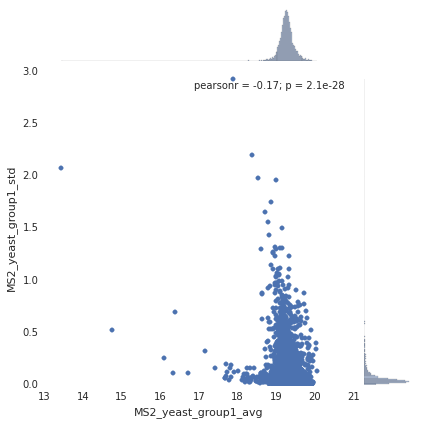

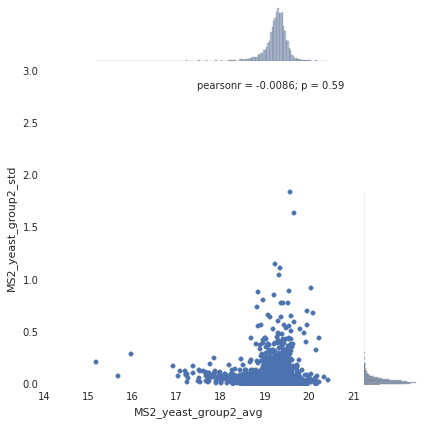

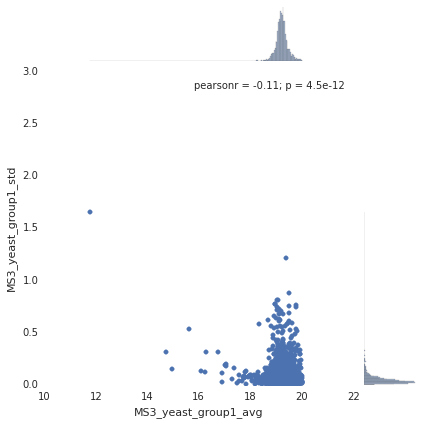

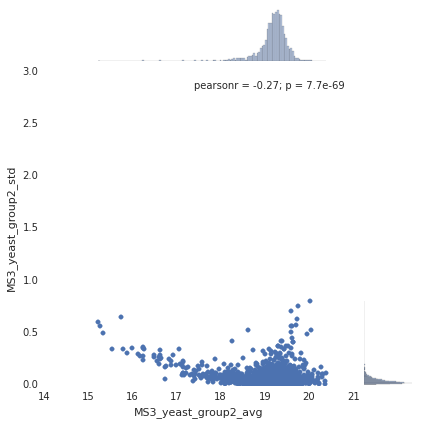

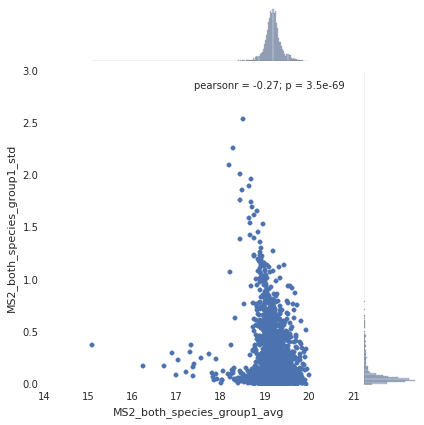

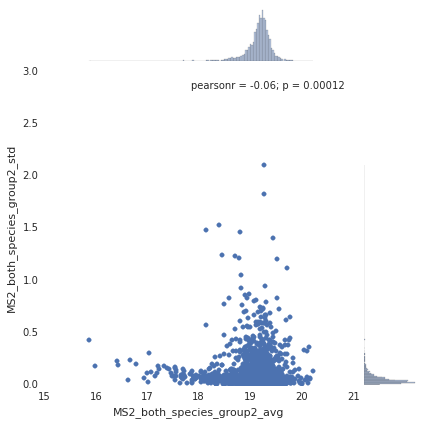

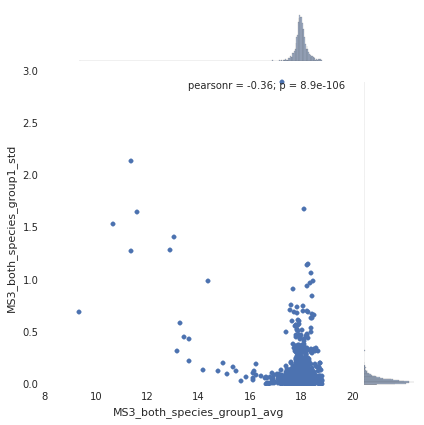

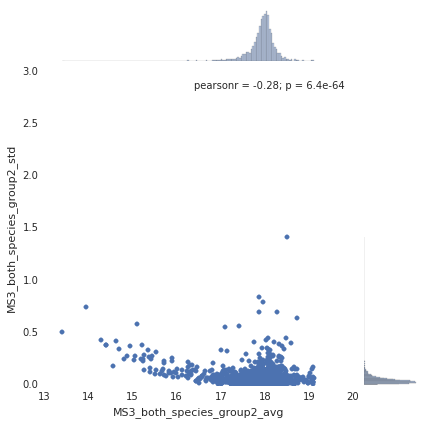

In [120]:
cols1 = ["126 Vert Med", "127n Vert Med", "127c Vert Med"]
cols2 = ["128n Vert Med", "128c Vert Med", "129n Vert Med"]

# merged = pandas.DataFrame()

for group, df in [("MS2_both_species", ms2_both_species), 
                  ("MS3_both_species", ms3_both_species), 
                  ("MS2_yeast", ms2_yeast), 
                  ("MS3_yeast", ms3_yeast)
                 ]:
    for setname, cols in [("group1", cols2), ("group2", cols1)]: 
        merged["%s_%s_avg" % (group, setname)] = pandas.Series(numpy.average(numpy.log2(df[cols]), axis=1), index=df.index)
        merged["%s_%s_std" % (group, setname)] = pandas.Series(numpy.std(numpy.log2(df[cols]), axis=1), index=df.index)

medianmedian = lambda v: numpy.median(numpy.abs(v - numpy.median(v)))

# print merged.head()
for group in ["MS2_yeast", "MS3_yeast", "MS2_both_species", "MS3_both_species"]:
    seaborn.jointplot("%s_group1_avg" % group, "%s_group1_std" % group, data=merged)
    pylab.ylim(0, 3)
    seaborn.jointplot("%s_group2_avg" % group, "%s_group2_std" % group, data=merged)
    print group, medianmedian(merged["%s_group1_std" % group]), medianmedian(merged["%s_group2_std" % group])
    pylab.ylim(0, 3)
pylab.show()

(0.73175761541899398, 0.00080577818094690356, 0.77525715747372004, 0.0, 0.0094338943214524618)
Beta: [ 1.09340656 -0.00238408]
Beta Std Error: [ 0.00976289  0.00059072]
Beta Covariance: [[ 1.94271123  0.01000309]
 [ 0.01000309  0.00711235]]
Residual Variance: 4.90623356892e-05
Inverse Condition #: 0.678902554135
Reason(s) for Halting:
  Sum of squares convergence
Beta: [  9.28237313e-01   3.22599320e-04]
Beta Std Error: [ 0.01045845  0.00042848]
Beta Covariance: [[ 0.2785521  -0.00068502]
 [-0.00068502  0.00046756]]
Residual Variance: 0.000392670602641
Inverse Condition #: 0.481714319749
Reason(s) for Halting:
  Sum of squares convergence


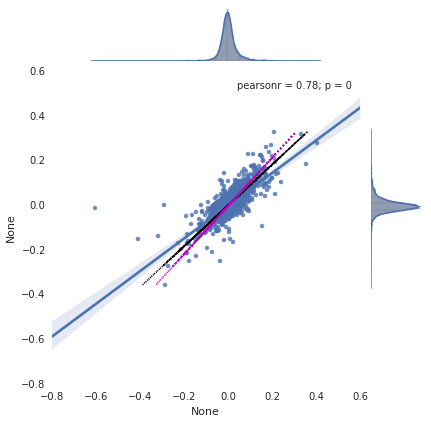

In [138]:
# total least squares regression with empirical standard deviations used in fitting, MS2
temp = numpy.log2(merged[["MS2_yeast_group1_avg", "MS2_yeast_group2_avg", 
                          "MS2_yeast_group1_std", "MS2_yeast_group2_std",
                          "MS2_both_species_group1_avg", "MS2_both_species_group2_avg", 
                          "MS2_both_species_group1_std", "MS2_both_species_group2_std",
                         ]].dropna())
x = temp[temp.columns[0]] - temp[temp.columns[1]]
y = temp[temp.columns[4]] - temp[temp.columns[5]]
sx = 0.5 * temp[temp.columns[2]] + 0.5 * temp[temp.columns[3]]
sy = 0.5 * temp[temp.columns[6]] + 0.5 * temp[temp.columns[7]]
print scipy.stats.linregress(x, y)

# pylab.plot(x, y, 'o', alpha=0.5)
seaborn.jointplot(x, y, kind="reg")
if True:
    model = scipy.odr.Model(lambda b, x : b[0]*x + b[1])
    data = scipy.odr.RealData(x, y, sx=sx, sy=sy)
    odr = scipy.odr.ODR(data, model, beta0=[1.0, 0.0])
    odr.set_job(fit_type=0) # 2 is vanilla least squares, which will match linregress (above)
    fit = odr.run()
    fit.pprint()
    pylab.plot(fit.beta[0]*y + fit.beta[1], y, "k:")
if True:
    model = scipy.odr.Model(lambda b, x : b[0]*x + b[1])
    data = scipy.odr.RealData(x, y)
    odr = scipy.odr.ODR(data, model, beta0=[1.0, 0.0])
    odr.set_job(fit_type=0) # 2 is vanilla least squares, which will match linregress (above)
    fit = odr.run()
    fit.pprint()
    pylab.plot(fit.beta[0]*y + fit.beta[1], y, "m:")

pylab.show()

(0.98985634499055786, 0.001008428630257084, 0.82799440883916198, 0.0, 0.011564685908413939)
Beta: [ 1.22996554 -0.00190744]
Beta Std Error: [ 0.01067278  0.00096061]
Beta Covariance: [[ 1.91779029 -0.01227772]
 [-0.01227772  0.01553598]]
Residual Variance: 5.93955677964e-05
Inverse Condition #: 0.908732748593
Reason(s) for Halting:
  Sum of squares convergence
Beta: [  1.24000427e+00   1.70818997e-04]
Beta Std Error: [ 0.01317504  0.00070797]
Beta Covariance: [[ 0.26241752 -0.00087869]
 [-0.00087869  0.00075774]]
Residual Variance: 0.000661471337383
Inverse Condition #: 0.620999420419
Reason(s) for Halting:
  Sum of squares convergence


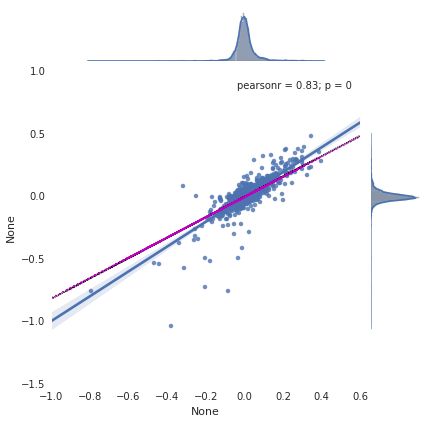

In [141]:
# total least squares regression with empirical standard deviations used in fitting, MS3
temp = numpy.log2(merged[["MS3_yeast_group1_avg", "MS3_yeast_group2_avg", 
                          "MS3_yeast_group1_std", "MS3_yeast_group2_std",
                          "MS3_both_species_group1_avg", "MS3_both_species_group2_avg", 
                          "MS3_both_species_group1_std", "MS3_both_species_group2_std",
                         ]].dropna())
x = temp[temp.columns[0]] - temp[temp.columns[1]]
y = temp[temp.columns[4]] - temp[temp.columns[5]]
sx = 0.5 * temp[temp.columns[2]] + 0.5 * temp[temp.columns[3]]
sy = 0.5 * temp[temp.columns[6]] + 0.5 * temp[temp.columns[7]]
print scipy.stats.linregress(x, y)

# pylab.plot(x, y, 'o', alpha=0.5)
seaborn.jointplot(x, y, kind="reg")
if True:
    model = scipy.odr.Model(lambda b, x : b[0]*x + b[1])
    data = scipy.odr.RealData(x, y, sx=sx, sy=sy)
    odr = scipy.odr.ODR(data, model, beta0=[1.0, 0.0])
    odr.set_job(fit_type=0) # 2 is vanilla least squares, which will match linregress (above)
    fit = odr.run()
    fit.pprint()
    pylab.plot(fit.beta[0]*y + fit.beta[1], y, "k:")
if True:
    model = scipy.odr.Model(lambda b, x : b[0]*x + b[1])
    data = scipy.odr.RealData(x, y)
    odr = scipy.odr.ODR(data, model, beta0=[1.0, 0.0])
    odr.set_job(fit_type=0) # 2 is vanilla least squares, which will match linregress (above)
    fit = odr.run()
    fit.pprint()
    pylab.plot(fit.beta[0]*y + fit.beta[1], y, "m:")
    
pylab.show()

(3996, 8)
(3596, 8)
(0.72895380717777036, 0.00079038061281365229, 0.77140141900029879, 0.0, 0.010030574270492122)
Beta: [  9.29270571e-01   2.94952486e-04]
Beta Std Error: [ 0.01114367  0.00041494]
Beta Covariance: [[ 0.37541779 -0.00092851]
 [-0.00092851  0.00052052]]
Residual Variance: 0.000330781620123
Inverse Condition #: 0.436628689526
Reason(s) for Halting:
  Sum of squares convergence
total least squares slope and intercept: [  9.29270571e-01   2.94952486e-04]


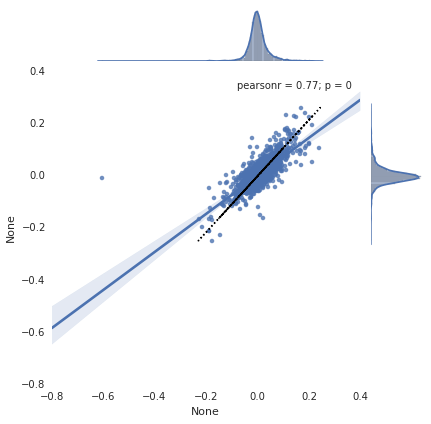

In [147]:
# total least squares regression after filtering genes with extreme variance, MS2
temp = numpy.log2(merged[["MS2_yeast_group1_avg", "MS2_yeast_group2_avg", 
                          "MS2_yeast_group1_std", "MS2_yeast_group2_std",
                          "MS2_both_species_group1_avg", "MS2_both_species_group2_avg", 
                          "MS2_both_species_group1_std", "MS2_both_species_group2_std",
                         ]].dropna())
sx = 0.5 * temp[temp.columns[2]] + 0.5 * temp[temp.columns[3]]
sy = 0.5 * temp[temp.columns[6]] + 0.5 * temp[temp.columns[7]]
noise = 0.5 * sx + 0.5 * sy
print temp.shape
temp = temp[noise < numpy.percentile(noise, 90)]
print temp.shape

x = temp[temp.columns[0]] - temp[temp.columns[1]]
y = temp[temp.columns[4]] - temp[temp.columns[5]]
print scipy.stats.linregress(x, y)

# pylab.plot(x, y, 'o', alpha=0.5)
seaborn.jointplot(x, y, kind="reg")
if True:
    model = scipy.odr.Model(lambda b, x : b[0]*x + b[1])
    data = scipy.odr.RealData(x, y)
    odr = scipy.odr.ODR(data, model, beta0=[1.0, 0.0])
    odr.set_job(fit_type=0) # 2 is vanilla least squares, which will match linregress (above)
    fit = odr.run()
    fit.pprint()
    print "total least squares slope and intercept:", fit.beta
    pylab.plot(fit.beta[0]*y + fit.beta[1], y, "k:")

pylab.show()

(3362, 8)
(3025, 8)
(0.89552343835848158, 0.0014477279343547208, 0.7757748575785216, 0.0, 0.013248243105264389)
Beta: [ 1.20274529  0.00126209]
Beta Std Error: [ 0.01560496  0.00064096]
Beta Covariance: [[  4.79507155e-01  -2.89731995e-04]
 [ -2.89731995e-04   8.08967040e-04]]
Residual Variance: 0.000507844012197
Inverse Condition #: 0.492761757378
Reason(s) for Halting:
  Sum of squares convergence
total least squares slope and intercept: [ 1.20274529  0.00126209]


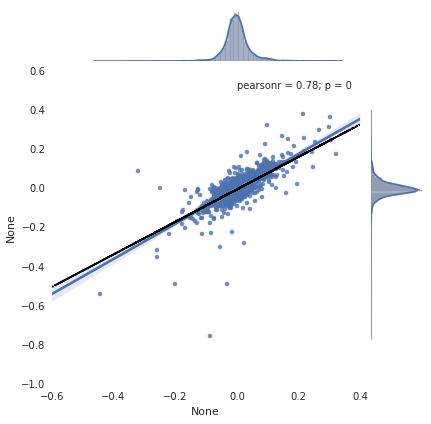

In [148]:
# total least squares regression after filtering genes with extreme variance, MS3
temp = numpy.log2(merged[["MS3_yeast_group1_avg", "MS3_yeast_group2_avg", 
                          "MS3_yeast_group1_std", "MS3_yeast_group2_std",
                          "MS3_both_species_group1_avg", "MS3_both_species_group2_avg", 
                          "MS3_both_species_group1_std", "MS3_both_species_group2_std",
                         ]].dropna())
sx = 0.5 * temp[temp.columns[2]] + 0.5 * temp[temp.columns[3]]
sy = 0.5 * temp[temp.columns[6]] + 0.5 * temp[temp.columns[7]]
noise = 0.5 * sx + 0.5 * sy
print temp.shape
temp = temp[noise < numpy.percentile(noise, 90)]
print temp.shape

x = temp[temp.columns[0]] - temp[temp.columns[1]]
y = temp[temp.columns[4]] - temp[temp.columns[5]]
print scipy.stats.linregress(x, y)

# pylab.plot(x, y, 'o', alpha=0.5)
seaborn.jointplot(x, y, kind="reg")
if True:
    model = scipy.odr.Model(lambda b, x : b[0]*x + b[1])
    data = scipy.odr.RealData(x, y)
    odr = scipy.odr.ODR(data, model, beta0=[1.0, 0.0])
    odr.set_job(fit_type=0) # 2 is vanilla least squares, which will match linregress (above)
    fit = odr.run()
    fit.pprint()
    pylab.plot(fit.beta[0]*y + fit.beta[1], y, "k:")
    print "total least squares slope and intercept:", fit.beta


pylab.show()

## Simulated results for testing

In [111]:
N = 1000
# true = scipy.stats.uniform.rvs(-5, 10, size=N)
true = scipy.stats.norm.rvs(0, 2, size=N)
x = true + scipy.stats.norm.rvs(0, 0.75, size=N)
y = true + scipy.stats.norm.rvs(0, 0.75, size=N)

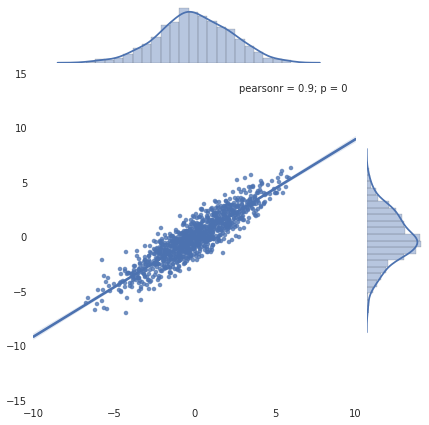

In [112]:
seaborn.jointplot(x, y, kind="reg")
pylab.show()

In [113]:
print scipy.stats.linregress(x, y)
print scipy.stats.linregress(y, x)

(0.90658908219426915, -0.044838777172072464, 0.89861832302364109, 0.0, 0.01401098001399515)
(0.89071764301346601, 0.042418127835704436, 0.89861832302364109, 0.0, 0.013765693123249292)


In [114]:
import scipy.odr
# quick version using the low-level function
print scipy.odr.odr(lambda b, x : b[0]*x + b[1], [1.0, 0.0], y, x, full_output=False)
print scipy.odr.odr(lambda b, x : b[0]*x + b[1], [1.0, 0.0], x, y, full_output=False)

(array([ 1.0098741 , -0.04616929]), array([ 0.01477389,  0.03187656]), array([[  4.33891043e-04,  -5.58904635e-06],
       [ -5.58904635e-06,   2.01991718e-03]]))
(array([ 0.99021953,  0.04571768]), array([ 0.01448636,  0.03156796]), array([[  4.17166301e-04,   1.38336051e-05],
       [  1.38336051e-05,   1.98099705e-03]]))


In [116]:
# expanded version
model = scipy.odr.Model(lambda b, x : b[0]*x + b[1])
data = scipy.odr.RealData(x, y)
odr = scipy.odr.ODR(data, model, beta0=[1.0, 0.0])
odr.set_job(fit_type=0) # 2 is vanilla least squares, which will match linregress (above)
fit = odr.run()
fit.pprint()
print "\n"
data = scipy.odr.RealData(y, x)
odr = scipy.odr.ODR(data, model, beta0=[1.0, 0.0])
odr.set_job(fit_type=0) # 2 is vanilla least squares, which will match linregress (above)
fit = odr.run()
fit.pprint()

Beta: [ 1.0098741  -0.04616929]
Beta Std Error: [ 0.01477389  0.03187656]
Beta Covariance: [[  4.33891043e-04  -5.58904635e-06]
 [ -5.58904635e-06   2.01991718e-03]]
Residual Variance: 0.50304782031
Inverse Condition #: 0.048376504115
Reason(s) for Halting:
  Sum of squares convergence


Beta: [ 0.99021953  0.04571768]
Beta Std Error: [ 0.01448636  0.03156796]
Beta Covariance: [[  4.17166301e-04   1.38336051e-05]
 [  1.38336051e-05   1.98099705e-03]]
Residual Variance: 0.503047820309
Inverse Condition #: 0.0478539069192
Reason(s) for Halting:
  Sum of squares convergence


Notice that the simple least squares estimates are downwardly-biased ($0.88$ here).  The total least squares estimates are much more accurate ($1.00$).
